In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
import os
import glob
import csv
import itertools as it
import operator as op
from functools import reduce
from collections import namedtuple
import random

import numpy as np

import matplotlib.image as mpimg
import matplotlib.colors
import skimage
import skimage.color
from skimage.feature import hog
import cv2

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier

# Annotated Driving Dataset

In [3]:
box = namedtuple("box", ("xmin", "xmax", "ymin", "ymax"))

def not_intersect(box_1, box_2):
    return (box_1.ymin < box_2.xmin) or \
           (box_2.ymin < box_1.xmin) or \
           (box_1.ymax < box_2.xmax) or \
           (box_2.ymax < box_1.xmax)


def random_frame(image_shape):
    height, width, _ = image_shape
    
    randx = np.random.randint(low=150, high=width-150)
    randy = np.random.randint(low=150, high=height-150) 
    
    frame_size = random.choice([64, 96, 128])
    
    return box(randx, randy, randx+frame_size, randy+frame_size)


def draw_boxes(img, bboxes, color=(255, 0, 0), thick=5):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [ ]:
# parse the dataset (this one is long)

if not os.path.exists("data/vehicles/add/"):
    os.makedirs("data/vehicles/add/")
    
if not os.path.exists("data/non-vehicles/add/"):
    os.makedirs("data/non-vehicles/add/")

with open("object-detection-crowdai/labels.csv") as rf:
    csv_reader = csv.reader(rf)
    next(csv_reader)
    
    for frame, group in it.groupby(csv_reader, op.itemgetter(4)):
        image = mpimg.imread("object-detection-crowdai/%s" % frame)
        frame = frame.partition('.')[0]

        # CARS
        car_boxes = []  
        truck_boxes = []
        for i, something_labeled in enumerate(group):
            xmin, xmax, ymin, ymax, _, label, _ = something_labeled
            xmin, xmax, ymin, ymax = int(xmin), int(xmax), int(ymin), int(ymax)
        
            if (label != 'Car') and (label != 'Truck'):
                continue
                
            if (ymin - xmin == 0) or (ymax - xmax == 0):
                print("Corrupted! Frame: %s Image: %d" % (frame, i), file=sys.stderr)
                continue
                
            # get relevant frame
            car_box = box(xmin, xmax, ymin, ymax)
            
            if label == 'Truck':
                truck_boxes.append(car_box)
                continue
            
            car_boxes.append(car_box)

            # save car frame
            car_img = image[car_box.xmax:car_box.ymax, car_box.xmin:car_box.ymin]
            car_img = cv2.resize(car_img, (64, 64))           
            mpimg.imsave('data/vehicles/add/%s_%d.png' % (frame, i), car_img)
            
            
        # NON_CARS
        random_frames = (random_frame(image.shape) for _ in it.count())
        non_overlapping_frames = (rf for rf in random_frames if all(not_intersect(f, rf) for f in (car_boxes + truck_boxes)))
        for i in range(len(car_boxes)):
            # get non-car frame
            non_car_box = next(non_overlapping_frames)
            non_car_boxes.append(non_car_box)
            
            # save non-car frame
            non_car_img = image[non_car_box.xmax:non_car_box.ymax, non_car_box.xmin:non_car_box.ymin]
            non_car_img = cv2.resize(non_car_img, (64, 64))           
            mpimg.imsave('data/non-vehicles/add/%s_%d.png' % (frame, i), non_car_img)

# Get some data

In [4]:
def get_pngs(path):
    for root, dirs, files in os.walk(path):
        pictures = (os.path.abspath(os.path.join(root, f)) for f in files if f.endswith(".png"))
        
        for p in pictures:
            yield p

In [5]:
def get_features(image):
    gray = skimage.color.rgb2gray(image)
    hog_features = hog(gray, 
                       orientations=10,
                       pixels_per_cell=(12, 12),
                       cells_per_block=(1, 1),
                       transform_sqrt=True)

        
    return hog_features


def bulk_get_features(image_files, raw=False):
    for f in image_files:
        image = mpimg.imread(f)
        if raw:
            yield image
        else:
            yield get_features(image)
            
            
# TRAIN 

X_train = []
y_train = []

car_train_images = it.chain(*map(get_pngs, ("data/vehicles/GTI_Far/",
                                            "data/vehicles/GTI_Left/",
                                            "data/vehicles/GTI_MiddleClose/",
                                            "data/vehicles/GTI_Right/",
                                            "data/vehicles/add/")))

non_car_train_images = it.chain(*map(get_pngs, ("data/non-vehicles/GTI/",
                                                "data/non-vehicles/add/")))

for f in bulk_get_features(car_train_images):
    X_train.append(f)
    y_train.append(1)

for f in bulk_get_features(non_car_train_images):
    X_train.append(f)
    y_train.append(0)    
    
X_train = np.array(X_train)
y_train = np.array(y_train)

# VALIDATION

car_val_images = get_pngs("data/vehicles/KITTI_extracted/")

non_car_val_images = get_pngs("data/non-vehicles/Extras/")

X_val = []
y_val = []

for f in bulk_get_features(car_val_images):
    X_val.append(f)
    y_val.append(1)

for f in bulk_get_features(non_car_val_images):
    X_val.append(f)
    y_val.append(0)    
    
X_val = np.array(X_val)
y_val = np.array(y_val)

In [6]:
n = X_train.shape[0]

shuff_idx = np.random.permutation(n)

X_train = X_train[shuff_idx]
y_train = y_train[shuff_idx]

# ---------------

m = X_val.shape[0]

shuff_idx = np.random.permutation(m)

X_val = X_val[shuff_idx]
y_val = y_val[shuff_idx]

In [7]:
# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train, axis=0, keepdims=True)
X_train -= mean_feat
X_val -= mean_feat

# Preprocessing: Divide by standard deviation.
std_feat = np.std(X_train, axis=0, keepdims=True)
X_train /= std_feat
X_val /= std_feat

# Machine Learning

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable

In [9]:
mini_batch_size = 256

In [10]:
class MyAwesomeNet(nn.Module):


    def __init__(self):
        super(MyAwesomeNet, self).__init__()

        self.fc1 = nn.Linear(250, 50)
        self.fc1_bn = nn.BatchNorm1d(50)
                
        self.fc_final = nn.Linear(50, 2)


    def forward(self, x):
        x = F.elu(self.fc1_bn(self.fc1(x)))
        x = self.fc_final(x)

        return x

In [11]:
net = MyAwesomeNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0003, weight_decay=0.0001)

In [12]:
train = data_utils.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
train_loader = data_utils.DataLoader(train, batch_size=mini_batch_size, 
                                     shuffle=True)

X_val = torch.from_numpy(X_val).float() 
y_val = torch.from_numpy(y_val)

In [13]:
X_val_var, y_val_var = Variable(X_val), Variable(y_val)

for epoch in range(15): # loop over the dataset multiple times
    net.train()
    
    running_loss = 0
    iteration_count = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()        
        optimizer.step()
        
        running_loss += loss.data[0]
        iteration_count += 1
        
    # print statistics
    net.eval()
    val_loss = criterion(net(X_val_var), y_val_var).data[0]
    print("Iteration %3d: Training Error: %.5f, Validation Erro: %5f" % (epoch, running_loss / iteration_count, val_loss))

print('Finished Training')

Iteration   0: Training Error: 0.28170, Validation Erro: 0.338341
Iteration   1: Training Error: 0.19321, Validation Erro: 0.350508
Iteration   2: Training Error: 0.15528, Validation Erro: 0.286003
Iteration   3: Training Error: 0.13162, Validation Erro: 0.265374
Iteration   4: Training Error: 0.11760, Validation Erro: 0.257950
Iteration   5: Training Error: 0.10892, Validation Erro: 0.231650
Iteration   6: Training Error: 0.10220, Validation Erro: 0.230862
Iteration   7: Training Error: 0.09698, Validation Erro: 0.212475
Iteration   8: Training Error: 0.09246, Validation Erro: 0.216935
Iteration   9: Training Error: 0.08857, Validation Erro: 0.222301
Iteration  10: Training Error: 0.08586, Validation Erro: 0.191443
Iteration  11: Training Error: 0.08304, Validation Erro: 0.210182
Iteration  12: Training Error: 0.08090, Validation Erro: 0.209592
Iteration  13: Training Error: 0.07816, Validation Erro: 0.198489
Iteration  14: Training Error: 0.07671, Validation Erro: 0.207763
Finished T

In [14]:
net.eval()

outputs = net(Variable(X_val))
sum(np.argmax(outputs.data.numpy(), axis=1) == y_val.numpy()) / X_val.size()[0]

0.91172738807322817

# The Solution

In [15]:
from scipy.ndimage.measurements import label

In [97]:
# functions taken from udacity tutorial

def slide_window(img, 
                 x_start_stop, 
                 y_start_stop, 
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            if endx < x_start_stop[1] and endy < y_start_stop[1]:
                window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list


def get_labeled_bboxes(labels):
    result = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if (bbox[1][0] - bbox[0][0] > 60) and (bbox[1][1] - bbox[0][1] > 60):
            result.append(bbox)
    # Return the image
    return result

In [22]:
test_images = glob.glob('test_images/*.jpg')

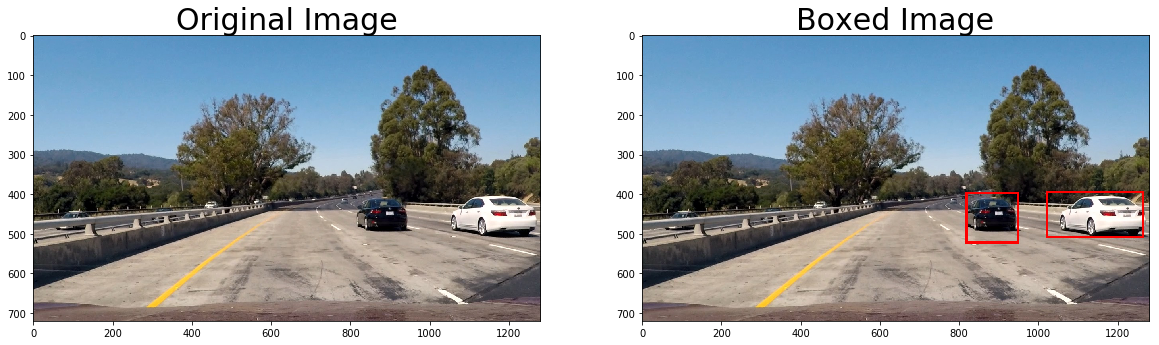

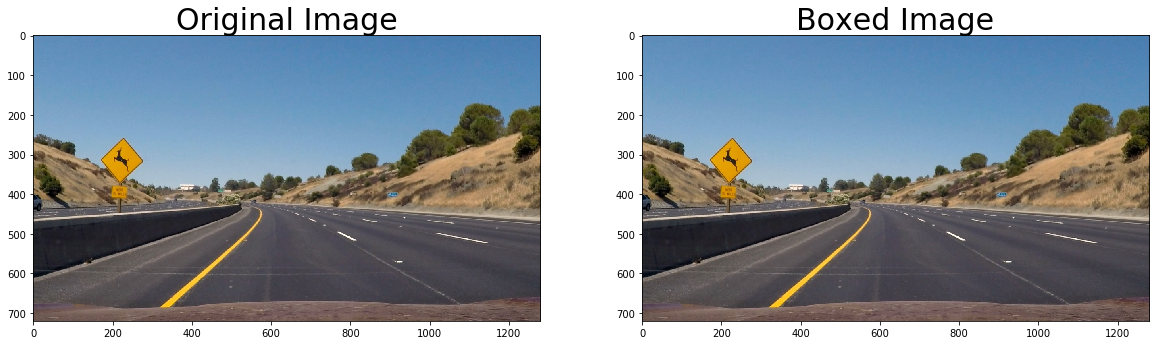

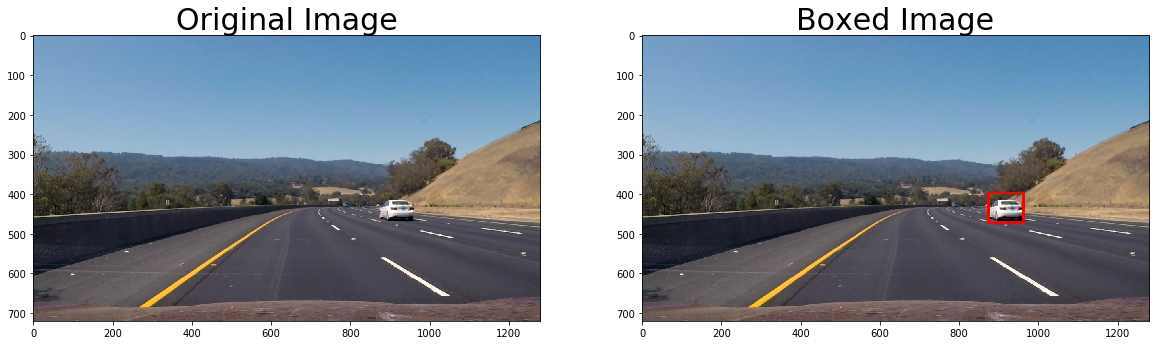

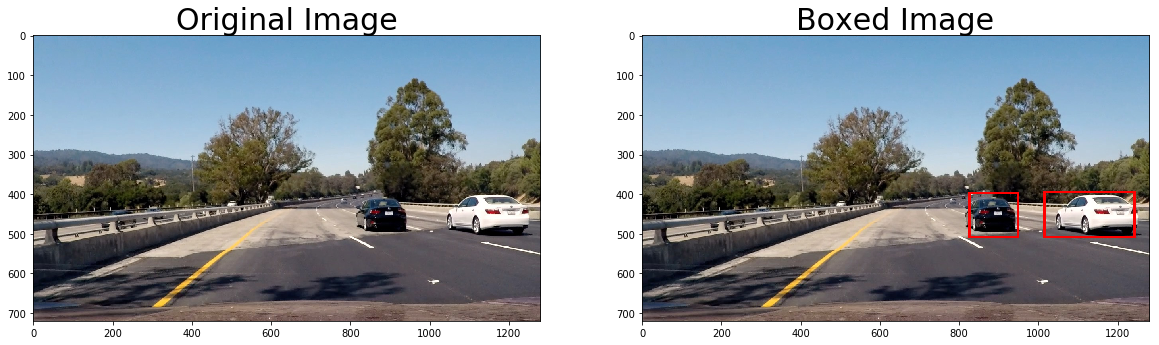

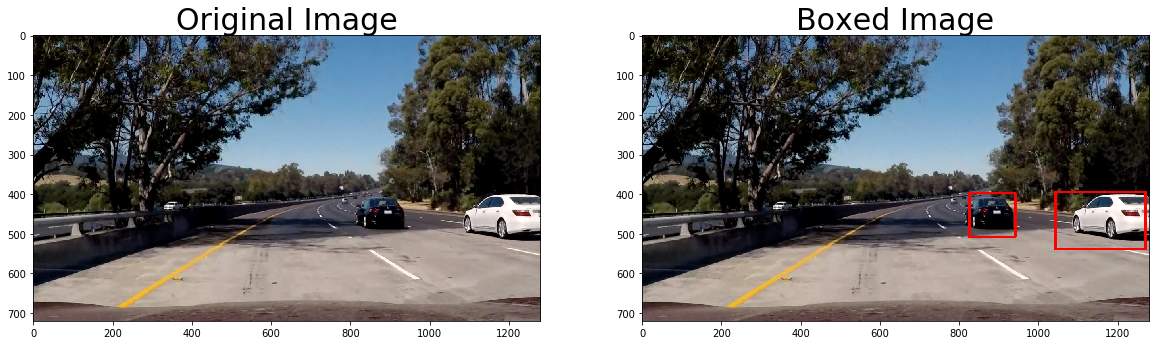

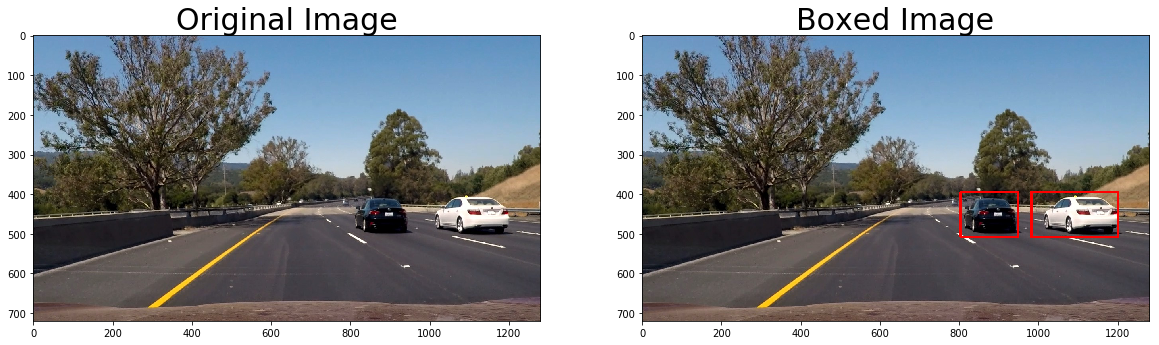

In [119]:
def get_active_windows(image):
    height, width, _ = image.shape
    
    windows = slide_window(image, [width // 2 + 100, width], [height // 2 + 35, height // 2 + 250], xy_window=(96, 96))
    windows.extend(slide_window(image, [width // 2 + 100, width], [height // 2 + 35, height // 2 + 300], xy_window=(128, 128)))
    windows.extend(slide_window(image, [width // 2 + 100, width], [height // 2 + 37, height // 2 + 200], xy_window=(75, 75), xy_overlap=(0.9, 0.5)))
    crops = [image[w[0][1]:w[1][1], w[0][0]: w[1][0]] for w in windows]
    resized = (cv2.resize(c, (64, 64)) for c in crops)
    
    features = np.array([get_features(c) for c in resized])
    features -= mean_feat
    features /= std_feat
    
    outputs = net(Variable(torch.from_numpy(features).float())).data.numpy()
    predicted = (outputs[:,1] > 1.1) & (outputs[:,0] < -0.1)
    
    return [windows[i] for i, result in enumerate(predicted) if result == 1]


def add_heat(heatmap, box_list):
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            
    # Return updated heatmap
    return heatmap
        

for test_img in test_images:
    image = mpimg.imread(test_img)

    active_windows = get_active_windows(image.astype(np.float) / 255)

    heat = np.zeros_like(image[:,:,0])
    heatmap = add_heat(heat, active_windows)
    
    heatmap[heatmap <= 2] = 0
        
    labels = label(heatmap)
    boxes = get_labeled_bboxes(labels)
    
    boxed = draw_boxes(image, boxes)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(boxed)
    ax2.set_title('Boxed Image', fontsize=30)
    
    mpimg.imsave('output_images/%s' % test_img.rpartition('/')[-1], boxed)

# Video

In [26]:
from collections import deque

In [27]:
from moviepy.editor import VideoFileClip

In [95]:
def process_image(image):
    active_windows = get_active_windows(image.astype(np.float) / 255)
    heat = np.zeros_like(image[:,:,0])
    heatmap = add_heat(heat, active_windows)
    heatmap[heatmap <= 2] = 0
    heatmap[heatmap != 0] = 1
    d.append(heatmap)
    
    heatmap = sum(d)
    heatmap[heatmap < 7] = 0
    heatmap[heatmap != 0] = 1
            
    labels = label(heatmap)
    boxes = get_labeled_bboxes(labels)
    
    boxed = draw_boxes(image, boxes)
    
    return boxed

In [99]:
d = deque(maxlen=10)

video_input = "project_video.mp4"
video_output = "output_videos/project_video_done.mp4"

clip = VideoFileClip(video_input)
processed_clip = clip.fl_image(lambda x: process_image(x))
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_done.mp4
[MoviePy] Writing video output_videos/project_video_done.mp4


100%|█████████▉| 1260/1261 [06:35<00:00,  3.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_done.mp4 

CPU times: user 6min 9s, sys: 19.1 s, total: 6min 28s
Wall time: 6min 37s
